# DATA 612: Project 2 - User- and Item- Based Collaborative Filtering (CF) Using Nearest Neighbors

**Derek G. Nokes**
**2019-06-18**

In [468]:
import numpy as np
from scipy.sparse import rand as sprand
import requests
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Introduction

Collaborative filtering systems need to compare two fundamentally different types of objects in order to establish recommendations - namely items and users.There are essentially two broad approaches to facilitate such a comparison: the neighborhood approach and latent factor model approach. In this project, we focus on evaluating different neighborhood approaches, testing both user-based and item-based models. We use the well-known movielens-100k dataset to explore different models and similarity metrics.


## Data Acquisition 

In this section we download the movielens data.


In [46]:
%matplotlib inline

We define a function to download the movielens data:

In [47]:
# function to download movielens data
def download(download_url, download_path):

    req = requests.get(download_url, stream=True)

    with open(download_path, 'wb') as fd:
        for chunk in req.iter_content(chunk_size=2**20):
            fd.write(chunk)


We download the data:

In [48]:
# define download path
download_path='/projects/ms/github/DATA_612/Project_2/ml-100k.zip'
# define download URL
download_url='http://files.grouplens.org/datasets/movielens/ml-100k.zip'
# dowload movielens data
download(download_url, download_path)


We extract the data from the zip file and read it into memory:

In [49]:
# define unzip path
unzip_path='/projects/ms/github/DATA_612/Project_2/'
# unzip movielens data
zf = zipfile.ZipFile(download_path)
user_by_item_file=zf.extract('ml-100k/u.data', unzip_path)
title_by_item_file=zf.extract('ml-100k/u.item', unzip_path)

# read movielens data into dataframe
df_user_by_item = pd.read_csv(user_by_item_file, sep='\t',header=None,
    names=['user_id','item_id','rating','titmestamp'])
df_title_by_item = pd.read_csv(title_by_item_file, sep='|',encoding='latin-1',
    header=None,usecols=[0,1],names=['item_id', 'title'])# join the ratings by user and item to the title
df = pd.merge(df_title_by_item,df_user_by_item, on='item_id')


## Data Exploration

In this section, we quickly explore the data.


In [50]:
# display top 5 lines
df.head()

,item_id,title,user_id,rating,titmestamp
0,1,Toy Story (1995),308,4,887736532
1,1,Toy Story (1995),287,5,875334088
2,1,Toy Story (1995),148,4,877019411
3,1,Toy Story (1995),280,4,891700426
4,1,Toy Story (1995),66,3,883601324


We compute basic summary statistics for the items, users, and ratings:

In [51]:
df.describe()

,item_id,user_id,rating,titmestamp
count,100000.000000,100000.00000,100000.000000,1.000000e+05
mean,425.530130,462.48475,3.529860,8.835289e+08
std,330.798356,266.61442,1.125674,5.343856e+06
min,1.000000,1.00000,1.000000,8.747247e+08
25%,175.000000,254.00000,3.000000,8.794487e+08
50%,322.000000,447.00000,4.000000,8.828269e+08
75%,631.000000,682.00000,4.000000,8.882600e+08
max,1682.000000,943.00000,5.000000,8.932866e+08


In [52]:
rating = pd.DataFrame(df.groupby('item_id')['rating'].mean())
rating['number_of_ratings'] = df.groupby('item_id')['rating'].count()


In [53]:
rating.head()

,rating,number_of_ratings
item_id,,
1,3.878319,452
2,3.206107,131
3,3.033333,90
4,3.550239,209
5,3.302326,86


Text(0.5, 0, 'Items')

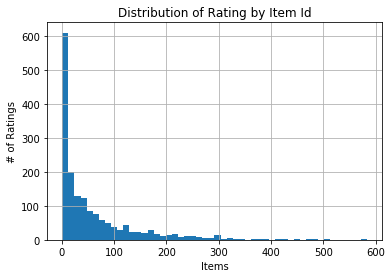

In [56]:
# plot distribution of rating by item id
rating['number_of_ratings'].hist(bins=50)
plt.title("Distribution of Rating by Item Id")
plt.ylabel('# of Ratings')
plt.xlabel('Items')


We can see that top 100 movies acount for the vast majority of the ratings


In [57]:
number_of_ratings_by_title = df.groupby('title')['rating'].count().sort_values(ascending=False)[:10]

In [58]:
number_of_ratings_by_title

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64

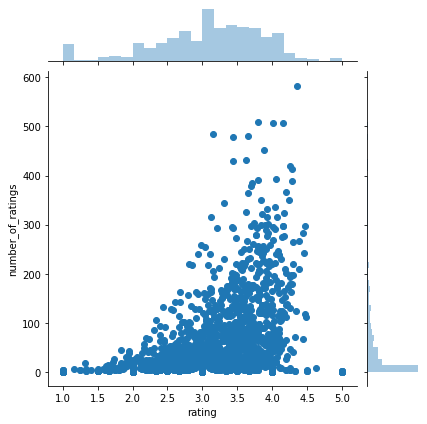

In [462]:
import seaborn as sns
sns.jointplot(x='rating', y='number_of_ratings', data=rating)

In [60]:
user_by_item_matrix = df.pivot_table(index='user_id', columns='item_id', values='rating')

In [61]:
user_by_item_matrix.tail()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
943,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# create mean rating by user
mean_rating_by_user=user_by_item_matrix.mean(axis=1)
# create mean rating by item
mean_rating_by_item=user_by_item_matrix.mean(axis=0)


Text(0.5, 0, 'Mean Rating')

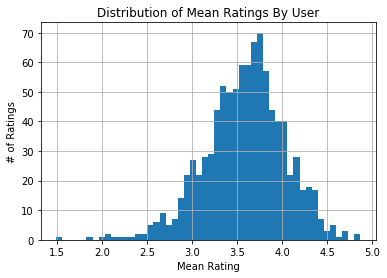

In [460]:
# plot mean rating by user
mean_rating_by_user.hist(bins=50)
plt.title("Distribution of Mean Ratings By User")
plt.ylabel('# of Ratings')
plt.xlabel('Mean Rating')

Text(0.5, 0, 'Mean Rating')

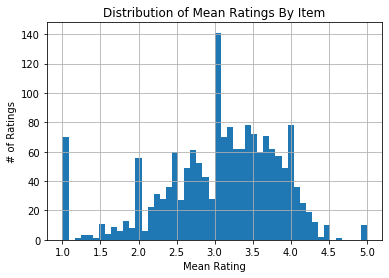

In [461]:
# plot mean rating by item
mean_rating_by_item.hist(bins=50)
plt.title("Distribution of Mean Ratings By Item")
plt.ylabel('# of Ratings')
plt.xlabel('Mean Rating')

# Theory

## Notation Summary
Throughout this project we employ the following notation:

$R$ represents the set of all ratings.

$R_{train}$ is the training set.

$R_{test}$ is the test set.

$\hat{R}$ is the set of predicted ratings.

The set of all users $U$ is composed of pairs of users $u$ and $v$.

The set of all items $I$ is composed of pairs of items $i$ and $j$.

$U_{i}$ indicates the set of all users that have rated item $i$.

$U_{ij}$ indicates the set of all users that have rated both items $i$ and $j$.

$I_{u}$ is the set of all items rated by user $u$.

$I_{uv}$ denotes the set of all items rated by users $u$ and $v$.

$r_{ui}$ represents the true rating of user $u$ for item $i$.

$\hat{r}_{ui}$ is the estimated rating of user $u$ for item $i$.

$b_{ui}$ is the baseline rating of user $u$ for item $i$.

$\mu$ is the mean of all ratings.

$\mu_{u}$ is the mean of all ratings given by user $u$.

$\mu_{i}$ is the mean of all ratings given to item $i$.

$\sigma_{u}$ is the standard deviation of all ratings given by user $u$.

$\sigma_{i}$ is the standard deviation of all ratings given to item $i$.

$N_{i}^{k}(u)$ denotes the $k$ nearest neighbors of user $u$ that have rated item $i$.

$N_{u}^{k}(i)$ represents the $k$ nearest neighbors of item $i$ that have been rated by user $u$.

$\text{sim(u,v)}$ metric measuring the similarity between users $u$ and $v$

$\text{sim(i,i)}$ metric measuring the similarity between items $i$ and $j$

## Similarity Metrics
In the application sections below, we compare the results of several recommendation algorithms for a number of different similarity metrics:

### Cosine Similarity

#### User-Based:
$$\text{cosine_sim}(u, v)=\frac{\sum_{i \in I_{uv}} r_{ui} \cdot r_{vi}}{\sqrt{\sum_{i \in I_{uv}} r_{ui}^2}\cdot\sqrt{\sum_{i \in I_{uv}} r_{vi}^2}}$$

#### Item-Based:
$$\text{cosine_sim}(i, j)=\frac{\sum_{u \in U_{ij}} r_{ui} \cdot r_{uj}}{\sqrt{\sum_{u \in U_{ij}} r_{ui}^2}\cdot\sqrt{\sum_{u \in U_{ij}} r_{uj}^2}}$$

### Mean Squared Difference (MSD)
We compute the Mean Squared Difference (MSD) similarity between all pairs of users (or items) as follows:
For common users (or items), the Mean Squared Difference is defined as:

#### User-Based:
$$\text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum_{i \in I_{uv}} (r_{ui} - r_{vi})^2$$

User=based MSD-similarity is defined as:

$$\text{msd_sim}(u, v) = \frac{1}{\text{msd}(u, v) + 1}$$

where +1 is used to ensure that we do not divide by zero.

#### Item-Based:
$$\text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum_{u \in U_{ij}} (r_{ui} - r_{uj})^2$$

Item-based MSD-similarity is defined as:

$$\text{msd_sim}(i, j) = \frac{1}{\text{msd}(i, j) + 1}$$

### Pearson Correlation Coefficient
For common users (or items), the Pearson Correlation coefficient is computed between all pairs of users (or items) and is defined as:

#### User-Based:
$$\text{pearson_sim}(u, v) = \frac{ \sum_{i \in I_{uv}}(r_{ui} -  \mu_u) \cdot (r_{vi} - \mu_{v})} {\sqrt{\sum_{i \in I_{uv}} (r_{ui} - \mu_u)^2} \cdot \sqrt{\sum_{i \in I_{uv}} (r_{vi} -  \mu_{v})^2} }$$

Similarity will be zero if there are no common users (or items).

#### Item-Based:
$$\text{pearson_sim}(i, j) = \frac{ \sum_{u \in U_{ij}}(r_{ui} -  \mu_i) \cdot (r_{uj} - \mu_{j})} {\sqrt{\sum_{u \in U_{ij}} (r_{ui} - \mu_i)^2} \cdot \sqrt{\sum_{u \in U_{ij}} (r_{uj} - \mu_{j})^2} }$$

### Pearson-Baseline Correlation Coefficient

#### User-Based:
$$\text{pearson_baseline_sim}(u, v) = \hat{\rho}_{uv} = \frac{ \sum_{i \in I_{uv}} (r_{ui} -  b_{ui}) \cdot (r_{vi} - b_{vi})} {\sqrt{\sum_{i \in I_{uv}} (r_{ui} -  b_{ui})^2} \cdot \sqrt{\sum_{i \in I_{uv}} (r_{vi} -  b_{vi})^2}}$$

#### Item-Based:
$$\text{pearson_baseline_sim}(i, j) = \hat{\rho}_{ij} = \frac{ \sum_{u \in U_{ij}} (r_{ui} -  b_{ui}) \cdot (r_{uj} - b_{uj})} {\sqrt{\sum_{u \in U_{ij}} (r_{ui} -  b_{ui})^2} \cdot \sqrt{\sum_{u \in U_{ij}} (r_{uj} -  b_{uj})^2}}$$

### Pearson-Baseline Correlation With Shrinkage
To reduce overfitting when only a few ratings are available, we can use shrinkage.
The Pearson correlation coefficient with shrinkage is computed between all pairs of users (or items) centered using baselines instead of means.

#### User-Based:
To apply shrinkage:

$$\text{pearson_baseline_shrunk_sim}(u, v) = \frac{|I_{uv}| - 1}{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}$$

To employ no shrinkage, the shrinkage parameter is set to zero.

Similarity will again be zero if there are no common users (or items).

#### Item-Based:
To apply shrinkage:
$$\text{pearson_baseline_shrunk_sim}(i, j) = \frac{|U_{ij}| - 1}{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}$$

## Memory-Based Collaborative Filtering (CF) - Nearest Neighbors

### Symmetric  Algorithms
All the algorithms evaluated in this section can be based on users or on items. Such algorithms are referred to as 'symmetric'. 

### Basic K-Nearest Neighbors (KNN-Basic)
The prediction $\hat{r}_{ui}$ is defined as:

#### User-Based:
$$\hat{r}_{ui} = \frac{\sum_{v \in N_{i}^{k}(u)}{\text{sim}(u, v) \cdot r_{vi}}}{\sum_{v \in N_{i}^{k}(u)}{\text{sim}(u, v)}}$$

This set is computed using a similarity metric.

#### Item-Based:
$$\hat{r}_{ui} = \frac{\sum_{j \in N_{u}^{k}(i)}{\text{sim}(i, j) \cdot r_{uj}}}{\sum_{j \in N_{u}^{k}(j)}{\text{sim}(i, j)}}$$

For item-based systems we use $\text{sim(i,j)}$.

It is important to note that the actual number of neighbors that are used to compute an estimate is necessarily less than or equal to $k$. In some cases, $k$ neighbors are not available. Additionally, sets $N_{i}^{k}(u)$ and $N_{u}^{k}(i)$ are comprised only of neighbors for which the similarity measure is positive (i.e., negatively correlated ratings from users (or items) are dissimilar and thus not recommended).

### Basic K-Nearest Neighbors (KNN-With Means)
We can extend the basic K-Nearest Neighbors (KNN) collaborative filtering algorithm to account for the mean ratings of each user (item).
The prediction $\hat{r}_{ui}$ is defined as:

#### User-Based:
$$\hat{r}_{ui} = \mu_{u} + \frac{ \sum_{v \in N_{i}^{k}(u)} \text{sim}(u, v) \cdot (r_{vi} - \mu_v) }{  \sum_{v \in N_{i}^{k}(u)} \text{sim}(u, v)}$$

#### Item-Based:
$$\hat{r}_{ui} = \mu_{i} + \frac{ \sum_{j \in N_{u}^{k}(i)} \text{sim}(i, j) \cdot (r_{uj} - \mu_j) }{  \sum_{j \in N_{u}^{k}(i)} \text{sim}(i, j)}$$

### Basic K-Nearest Neighbors (KNN-With Z-Score)
We can extend the K-Nearest Neighbors (KNN) collaborative filtering algorithm to account for both the mean and standard deviation of each rating of each user (item).
The prediction $\hat{r}_{ui}$ is defined as:

#### User-Based:
$$\hat{r}_{ui} = \mu_{u} + \sigma_{u} \frac{ \sum_{v \in N_{i}^{k}(u)} \text{sim}(u, v) \cdot (r_{vi} - \mu_v) / \sigma_v }{  \sum_{v \in N_{i}^{k}(u)} \text{sim}(u, v)}$$

#### Item-Based:
$$\hat{r}_{ui} = \mu_{i} + \sigma_{i} \frac{ \sum_{j \in N_{u}^{k}(i)} \text{sim}(i, j) \cdot (r_{uj} - \mu_j) / \sigma_j }{  \sum_{j \in N_{u}^{k}(i)} \text{sim}(i, j)}$$ 

### Basic K-Nearest Neighbors (KNN-Baseline)
We can extend the K-Nearest Neighbors (KNN) collaborative filtering algorithm to account for a baseline rating.
The prediction $\hat{r}_{ui}$ is defined as:

#### User-Based:
$$\hat{r}_{ui} = b_{ui} + \frac{ \sum_{v \in N_{i}^{k}(u)}\text{sim}(u, v) \cdot (r_{vi} - b_{vi})}{\sum_{v \in N_{i}^{k}(u)}\text{sim}(u, v)}$$

#### Item-Based:
$$\hat{r}_{ui} = b_{ui} + \frac{ \sum_{j \in N_{u}^{k}(i) } \text{sim}(i, j) \cdot (r_{uj} - b_{uj})}{ \sum_{j \in N_{u}^{k}(j)} \text{sim}(i, j)}$$

# Application

In this section we explore user-based and item-based nearest neighbor approaches to creating recommendations.


We create the data object required for the modeling below as follows:


In [455]:
df.head()

,item_id,title,user_id,rating,titmestamp
0,1,Toy Story (1995),308,4,887736532
1,1,Toy Story (1995),287,5,875334088
2,1,Toy Story (1995),148,4,877019411
3,1,Toy Story (1995),280,4,891700426
4,1,Toy Story (1995),66,3,883601324


In [456]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)


In [93]:
from surprise import BaselineOnly
from surprise import SVD
from surprise import NMF
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
import random
import numpy as np

randomSeed = 12345678

We set the random seed to ensure that our results are comparable across models and parameters.

In [96]:

random.seed(randomSeed)
np.random.seed(randomSeed)

# sample random trainset and testset
# test set is made of 75% of the ratings.
trainset, testset = train_test_split(data, test_size=.75)


In [466]:
# format results table
def formatResults(modelName,modelType,result):
    table=pd.DataFrame(result).T
    columnMapper={0 : 'Fold 1', 1 : 'Fold 2', 2 : 'Fold 3', 3 : 'Fold 4', 4 :'Fold 5'}
    rowMapper={'test_rmse' : 'RMSE (testset)', 'test_mae' : 'MAE (testset)',
        'fit_time' : 'Fit time', 'test_time' : 'Test time'}
    table.rename(axis=1,inplace=True,mapper=columnMapper)
    table.rename(axis=0,inplace=True,mapper=rowMapper)
    table['Mean']=table.mean(axis=1)
    table['Std']=table.std(axis=1)
    table['Model']=modelName
    table['Type']=modelType
    table=table[['Model','Type','Mean','Std','Fold 1','Fold 2','Fold 3','Fold 4','Fold 5']].round(4)        
    return table


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


## User-Based Collaborative Filtering (CF) - Nearest Neighbors

In this section, we use different configurations of nearest neighbor models to do user-based collaborative filtering.

In [464]:

random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between users
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# ompute RMSE
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0436


1.0435738636371283

We can fetch the top 10 recommendations for each user in the test set as follows:

In [483]:
# map item id to title 
item2Title=df_title_by_item.set_index('item_id')['title'].to_dict()
# get to 10 recommendation for each user
top_n = get_top_n(predictions, n=10)

# print recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [item2Title[iid] for (iid, _) in user_ratings])

521 ['Usual Suspects, The (1995)', 'Star Wars (1977)', 'To Kill a Mockingbird (1962)', 'Princess Bride, The (1987)', 'Empire Strikes Back, The (1980)', 'Godfather, The (1972)', 'Chasing Amy (1997)', 'Monty Python and the Holy Grail (1974)', 'Braveheart (1995)', 'Return of the Jedi (1983)']
405 ['Schizopolis (1996)', 'Horse Whisperer, The (1998)', 'Hugo Pool (1997)', 'Braindead (1992)', 'Gumby: The Movie (1995)', 'Star Wars (1977)', 'Shawshank Redemption, The (1994)', 'Boys of St. Vincent, The (1993)', 'North by Northwest (1959)', 'Godfather, The (1972)']
216 ['Shawshank Redemption, The (1994)', 'Close Shave, A (1995)', 'Star Wars (1977)', 'Usual Suspects, The (1995)', "One Flew Over the Cuckoo's Nest (1975)", 'Silence of the Lambs, The (1991)', 'Empire Strikes Back, The (1980)', "Schindler's List (1993)", 'Braveheart (1995)', 'Raiders of the Lost Ark (1981)']
478 ['Shawshank Redemption, The (1994)', 'Star Wars (1977)', 'To Kill a Mockingbird (1962)', "One Flew Over the Cuckoo's Nest (1

Although the recommendations look reasonable, we do not focus here are interpreting the results.

In [363]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNN_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [364]:
modelName='KNN Basic (MSD)'
modelType='User'
table_UB_KNNM_M=formatResults(modelName,modelType,result_UB_KNN_M)
table_UB_KNN_M

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,Std,Model,Type
RMSE (testset),0.980426,0.974115,0.983716,0.980322,0.975691,0.978854,0.003485,KNN Basic (MSD),User
MAE (testset),0.772721,0.768769,0.778249,0.775346,0.770759,0.773169,0.003344,KNN Basic (MSD),User
Fit time,0.259100,0.270059,0.272099,0.274057,0.272347,0.269532,0.005368,KNN Basic (MSD),User
Test time,4.330230,4.270131,4.262983,4.330625,4.417051,4.322204,0.055408,KNN Basic (MSD),User


In [365]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use cosine similarity
# compute similarities between items
sim_options = {'name': 'cosine','user_based': True}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNN_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [366]:
modelName='KNN Basic (Cosine)'
modelType='User'
table_UB_KNN_C=formatResults(modelName,modelType,result_UB_KNN_C)
table_UB_KNN_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Cosine),User,1.0168,0.0040,1.0180,1.0109,1.0226,1.0184,1.0142
MAE (testset),KNN Basic (Cosine),User,0.8041,0.0037,0.8034,0.7989,0.8098,0.8065,0.8019
Fit time,KNN Basic (Cosine),User,1.0252,0.0071,1.0136,1.0282,1.0350,1.0222,1.0272
Test time,KNN Basic (Cosine),User,4.3759,0.0391,4.3601,4.3308,4.4128,4.4310,4.3446


In [367]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': True}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNN_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [368]:
modelName='KNN Basic (Pearson)'
modelType='User'
table_UB_KNN_P=formatResults(modelName,modelType,result_UB_KNN_P)
table_UB_KNN_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Pearson),User,1.0113,0.0037,1.0125,1.0071,1.0167,1.0128,1.0073
MAE (testset),KNN Basic (Pearson),User,0.8027,0.0030,0.8023,0.8001,0.8074,0.8047,0.7990
Fit time,KNN Basic (Pearson),User,1.4521,0.0217,1.4502,1.4346,1.4485,1.4339,1.4932
Test time,KNN Basic (Pearson),User,4.3114,0.0591,4.2931,4.2956,4.2255,4.3376,4.4052


In [369]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': True}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNN_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [370]:
modelName='KNN Basic (Pearson Baseline - Shrinkage)'
modelType='User'
table_UB_KNN_PB=formatResults(modelName,modelType,result_UB_KNN_PB)
table_UB_KNN_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Pearson Baseline - Shrinkage),User,0.9994,0.0047,0.9998,0.9937,1.0062,1.0028,0.9947
MAE (testset),KNN Basic (Pearson Baseline - Shrinkage),User,0.7912,0.0044,0.7899,0.7867,0.7982,0.7942,0.7869
Fit time,KNN Basic (Pearson Baseline - Shrinkage),User,1.1383,0.0228,1.1106,1.1716,1.1564,1.1341,1.1191
Test time,KNN Basic (Pearson Baseline - Shrinkage),User,4.3498,0.0557,4.4479,4.3559,4.3444,4.2792,4.3214


In [371]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': True}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNN_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [372]:
modelName='KNN Basic (Pearson Baseline - No Shrinkage)'
modelType='User'
table_UB_KNN_PBN=formatResults(modelName,modelType,result_UB_KNN_PBN)
table_UB_KNN_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Pearson Baseline - No Shrinkage),User,1.0086,0.0043,1.0086,1.0038,1.0156,1.0105,1.0043
MAE (testset),KNN Basic (Pearson Baseline - No Shrinkage),User,0.7981,0.0040,0.7960,0.7946,0.8047,0.8007,0.7944
Fit time,KNN Basic (Pearson Baseline - No Shrinkage),User,1.1244,0.0085,1.1156,1.1338,1.1146,1.1342,1.1237
Test time,KNN Basic (Pearson Baseline - No Shrinkage),User,4.2560,0.0656,4.2378,4.2215,4.2057,4.3856,4.2296


### Basic K-Nearest Neighbors (KNN-With Means)



In [373]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between users
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9990


0.9990468644184224

In [374]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNM_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [375]:
modelName='KNN With Means (MSD)'
modelType='User'
table_UB_KNNM_M=formatResults(modelName,modelType,result_UB_KNNM_M)
table_UB_KNNM_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (MSD),User,0.9505,0.0037,0.9558,0.9478,0.9541,0.9470,0.9479
MAE (testset),KNN With Means (MSD),User,0.7491,0.0022,0.7515,0.7482,0.7520,0.7468,0.7472
Fit time,KNN With Means (MSD),User,0.3028,0.0062,0.2966,0.3145,0.3026,0.2986,0.3020
Test time,KNN With Means (MSD),User,4.7044,0.0372,4.6825,4.7381,4.7555,4.6918,4.6542


In [376]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNM_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [377]:
modelName='KNN With Means (Cosine)'
modelType='User'
table_UB_KNNM_C=formatResults(modelName,modelType,result_UB_KNNM_C)
table_UB_KNNM_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Cosine),User,0.9505,0.0037,0.9558,0.9478,0.9541,0.9470,0.9479
MAE (testset),KNN With Means (Cosine),User,0.7491,0.0022,0.7515,0.7482,0.7520,0.7468,0.7472
Fit time,KNN With Means (Cosine),User,0.3018,0.0035,0.2965,0.3074,0.3024,0.3001,0.3025
Test time,KNN With Means (Cosine),User,4.6670,0.0453,4.6369,4.7336,4.6107,4.7049,4.6486


In [378]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': True}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNM_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [379]:
modelName='KNN With Means (Pearson)'
modelType='User'
table_UB_KNNM_P=formatResults(modelName,modelType,result_UB_KNNM_P)
table_UB_KNNM_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Pearson),User,0.9492,0.0040,0.9549,0.9486,0.9526,0.9445,0.9454
MAE (testset),KNN With Means (Pearson),User,0.7437,0.0021,0.7462,0.7437,0.7458,0.7415,0.7412
Fit time,KNN With Means (Pearson),User,1.4744,0.0058,1.4649,1.4796,1.4771,1.4705,1.4799
Test time,KNN With Means (Pearson),User,4.6583,0.0705,4.7325,4.6095,4.5610,4.6448,4.7437


In [380]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': True}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNM_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [381]:
modelName='KNN With Means (Pearson Baseline - No Shrinkage)'
modelType='User'
table_UB_KNNM_PB=formatResults(modelName,modelType,result_UB_KNNM_PB)
table_UB_KNNM_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Pearson Baseline - No Shrinkage),User,0.9368,0.0036,0.9416,0.9340,0.9405,0.9353,0.9327
MAE (testset),KNN With Means (Pearson Baseline - No Shrinkage),User,0.7301,0.0023,0.7319,0.7286,0.7330,0.7303,0.7265
Fit time,KNN With Means (Pearson Baseline - No Shrinkage),User,1.1476,0.0155,1.1498,1.1445,1.1420,1.1269,1.1746
Test time,KNN With Means (Pearson Baseline - No Shrinkage),User,4.5843,0.0722,4.5580,4.5212,4.5022,4.6685,4.6714


In [382]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': True}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNM_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [383]:
modelName='KNN With Means (Pearson Baseline - Shrinkage)'
modelType='User'
table_UB_KNNM_PBN=formatResults(modelName,modelType,result_UB_KNNM_PBN)
table_UB_KNNM_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Pearson Baseline - Shrinkage),User,0.9500,0.0040,0.9555,0.9479,0.9539,0.9463,0.9462
MAE (testset),KNN With Means (Pearson Baseline - Shrinkage),User,0.7447,0.0022,0.7473,0.7440,0.7472,0.7433,0.7417
Fit time,KNN With Means (Pearson Baseline - Shrinkage),User,1.1509,0.0192,1.1853,1.1337,1.1482,1.1324,1.1548
Test time,KNN With Means (Pearson Baseline - Shrinkage),User,4.5896,0.0558,4.5431,4.6714,4.5130,4.6075,4.6131


### Basic K-Nearest Neighbors (KNN-With Z-Score)



In [384]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between users
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0003


1.0002556612572022

In [385]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNZ_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [386]:
modelName='KNN With Z-Score (MSD)'
modelType='User'
table_UB_KNNZ_M=formatResults(modelName,modelType,result_UB_KNNZ_M)
table_UB_KNNZ_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (MSD),User,0.9507,0.0037,0.9556,0.9466,0.9546,0.9482,0.9484
MAE (testset),KNN With Z-Score (MSD),User,0.7460,0.0023,0.7483,0.7440,0.7492,0.7443,0.7442
Fit time,KNN With Z-Score (MSD),User,0.3646,0.0076,0.3524,0.3650,0.3727,0.3607,0.3721
Test time,KNN With Z-Score (MSD),User,5.0145,0.0607,5.0165,5.1160,4.9278,5.0216,4.9907


In [387]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'cosine','user_based': True}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNZ_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [388]:
modelName='KNN With Z-Score (Cosine)'
modelType='User'
table_UB_KNNZ_C=formatResults(modelName,modelType,result_UB_KNNZ_C)
table_UB_KNNZ_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Cosine),User,0.9548,0.0039,0.9600,0.9511,0.9590,0.9511,0.9526
MAE (testset),KNN With Z-Score (Cosine),User,0.7511,0.0026,0.7541,0.7490,0.7544,0.7488,0.7492
Fit time,KNN With Z-Score (Cosine),User,1.1115,0.0075,1.0994,1.1187,1.1194,1.1127,1.1071
Test time,KNN With Z-Score (Cosine),User,5.0372,0.0789,5.1038,5.0260,4.9325,5.1466,4.9770


In [389]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': True}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNZ_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [390]:
modelName='KNN With Z-Score (Pearson)'
modelType='User'
table_UB_KNNZ_P=formatResults(modelName,modelType,result_UB_KNNZ_P)
table_UB_KNNZ_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Pearson),User,0.9477,0.0038,0.9521,0.9469,0.9520,0.9435,0.9439
MAE (testset),KNN With Z-Score (Pearson),User,0.7401,0.0020,0.7423,0.7396,0.7426,0.7384,0.7376
Fit time,KNN With Z-Score (Pearson),User,1.5623,0.0229,1.5434,1.5819,1.5958,1.5357,1.5548
Test time,KNN With Z-Score (Pearson),User,4.9896,0.0389,5.0065,4.9402,4.9913,5.0516,4.9584


In [391]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': True}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNZ_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [392]:
modelName='KNN With Z-Score (Pearson Baseline - Shrinkage)'
modelType='User'
table_UB_KNNZ_PB=formatResults(modelName,modelType,result_UB_KNNZ_PB)
table_UB_KNNZ_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Pearson Baseline - Shrinkage),User,0.9358,0.0038,0.9398,0.9322,0.9407,0.9348,0.9316
MAE (testset),KNN With Z-Score (Pearson Baseline - Shrinkage),User,0.7272,0.0028,0.7293,0.7249,0.7307,0.7277,0.7232
Fit time,KNN With Z-Score (Pearson Baseline - Shrinkage),User,1.1956,0.0083,1.1945,1.2018,1.2032,1.1801,1.1984
Test time,KNN With Z-Score (Pearson Baseline - Shrinkage),User,4.8244,0.0495,4.8547,4.8893,4.7557,4.8431,4.7788


In [393]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': True}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNZ_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [394]:
modelName='KNN With Z-Score (Pearson Baseline - No Shrinkage)'
modelType='User'
table_UB_KNNZ_PBN=formatResults(modelName,modelType,result_UB_KNNZ_PBN)
table_UB_KNNZ_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Pearson Baseline - No Shrink...,User,0.9495,0.0041,0.9538,0.9471,0.9553,0.9464,0.9452
MAE (testset),KNN With Z-Score (Pearson Baseline - No Shrink...,User,0.7423,0.0026,0.7446,0.7410,0.7459,0.7414,0.7388
Fit time,KNN With Z-Score (Pearson Baseline - No Shrink...,User,1.2008,0.0066,1.1941,1.2006,1.2031,1.2119,1.1942
Test time,KNN With Z-Score (Pearson Baseline - No Shrink...,User,4.8276,0.0508,4.9187,4.7873,4.7736,4.8249,4.8336


### Basic K-Nearest Neighbors (KNN-Baseline)



In [395]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between users
sim_options = {'name': 'msd','user_based': True}
# Build an algorithm, and train it.
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9780


0.9779730346506049

In [396]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'msd','user_based': True}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNB_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [397]:
modelName='KNN Baseline (MSD)'
modelType='User'
table_UB_KNNB_M=formatResults(modelName,modelType,result_UB_KNNB_M)
table_UB_KNNB_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (MSD),User,0.9298,0.0024,0.9316,0.9272,0.9335,0.9289,0.9280
MAE (testset),KNN Baseline (MSD),User,0.7328,0.0015,0.7316,0.7319,0.7356,0.7332,0.7315
Fit time,KNN Baseline (MSD),User,0.3785,0.0064,0.3812,0.3879,0.3807,0.3699,0.3729
Test time,KNN Baseline (MSD),User,5.3874,0.0930,5.4408,5.3055,5.2659,5.4006,5.5242


In [398]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# compute  similarities between items
sim_options = {'name': 'cosine','user_based': True}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNB_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [399]:
modelName='KNN Baseline (Cosine)'
modelType='User'
table_UB_KNNB_C=formatResults(modelName,modelType,result_UB_KNNB_C)
table_UB_KNNB_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Cosine),User,0.9333,0.0026,0.9351,0.9303,0.9374,0.9320,0.9315
MAE (testset),KNN Baseline (Cosine),User,0.7365,0.0017,0.7358,0.7350,0.7396,0.7367,0.7353
Fit time,KNN Baseline (Cosine),User,1.1147,0.0113,1.1358,1.1044,1.1171,1.1080,1.1084
Test time,KNN Baseline (Cosine),User,5.3555,0.0731,5.3690,5.3234,5.2786,5.4898,5.3164


In [400]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': True}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNB_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [401]:
modelName='KNN Baseline (Pearson)'
modelType='User'
table_UB_KNNB_P=formatResults(modelName,modelType,result_UB_KNNB_P)
table_UB_KNNB_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson),User,0.9308,0.0023,0.9326,0.9301,0.9341,0.9290,0.9281
MAE (testset),KNN Baseline (Pearson),User,0.7318,0.0013,0.7308,0.7319,0.7339,0.7323,0.7303
Fit time,KNN Baseline (Pearson),User,1.5419,0.0057,1.5404,1.5454,1.5362,1.5362,1.5511
Test time,KNN Baseline (Pearson),User,5.2774,0.0317,5.2987,5.2649,5.2262,5.3197,5.2773


In [402]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': True}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNB_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [403]:
modelName='KNN Baseline (Pearson Baseline) - Shrinkage'
modelType='User'
table_UB_KNNB_PB=formatResults(modelName,modelType,result_UB_KNNB_PB)
table_UB_KNNB_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson Baseline) - Shrinkage,User,0.9206,0.0027,0.9223,0.9178,0.9241,0.9216,0.9170
MAE (testset),KNN Baseline (Pearson Baseline) - Shrinkage,User,0.7207,0.0021,0.7194,0.7197,0.7232,0.7233,0.7181
Fit time,KNN Baseline (Pearson Baseline) - Shrinkage,User,1.1045,0.0081,1.1096,1.0971,1.1064,1.0938,1.1158
Test time,KNN Baseline (Pearson Baseline) - Shrinkage,User,5.1988,0.0381,5.2117,5.1794,5.1431,5.2009,5.2589


In [404]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': True}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_UB_KNNB_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [405]:
modelName='KNN Baseline (Pearson Baseline) - No Shrinkage'
modelType='User'
table_UB_KNNB_PBN=formatResults(modelName,modelType,result_UB_KNNB_PBN)
table_UB_KNNB_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson Baseline) - No Shrinkage,User,0.9294,0.0026,0.9311,0.9273,0.9336,0.9287,0.9265
MAE (testset),KNN Baseline (Pearson Baseline) - No Shrinkage,User,0.7302,0.0019,0.7287,0.7297,0.7331,0.7315,0.7280
Fit time,KNN Baseline (Pearson Baseline) - No Shrinkage,User,1.1199,0.0128,1.1202,1.1127,1.1444,1.1090,1.1131
Test time,KNN Baseline (Pearson Baseline) - No Shrinkage,User,5.2472,0.0729,5.2285,5.3306,5.1783,5.3345,5.1641


## Item-Based Collaborative Filtering (CF) - Nearest Neighbors

In this section, we use different configurations of nearest neighbor models to do item-based collaborative filtering.

In [406]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0492


1.0492238503628248

In [407]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNN_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [408]:
modelName='KNN Basic (MSD)'
modelType='Item'
table_IB_KNN_M=formatResults(modelName,modelType,result_IB_KNN_M)
table_IB_KNN_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (MSD),Item,0.9746,0.0060,0.9799,0.9727,0.9827,0.9724,0.9656
MAE (testset),KNN Basic (MSD),Item,0.7701,0.0048,0.7732,0.7700,0.7753,0.7706,0.7613
Fit time,KNN Basic (MSD),Item,0.4073,0.0044,0.4125,0.4108,0.4067,0.3996,0.4069
Test time,KNN Basic (MSD),Item,4.9288,0.0442,4.8990,4.9386,4.8906,5.0109,4.9047


In [409]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use cosine similarity
# compute similarities between items
sim_options = {'name': 'cosine','user_based': False}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNN_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [410]:
modelName='KNN Basic (Cosine)'
modelType='Item'
table_IB_KNN_C=formatResults(modelName,modelType,result_IB_KNN_C)
table_IB_KNN_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Cosine),Item,1.0264,0.0064,1.0310,1.0267,1.0350,1.0223,1.0168
MAE (testset),KNN Basic (Cosine),Item,0.8113,0.0050,0.8134,0.8130,0.8173,0.8107,0.8022
Fit time,KNN Basic (Cosine),Item,1.8764,0.0088,1.8854,1.8726,1.8687,1.8884,1.8670
Test time,KNN Basic (Cosine),Item,4.9271,0.0515,4.8709,4.9473,5.0173,4.8934,4.9065


In [411]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': False}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNN_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [412]:
modelName='KNN Basic (Pearson)'
modelType='Item'
table_IB_KNN_P=formatResults(modelName,modelType,result_IB_KNN_P)
table_IB_KNN_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Pearson),Item,1.0413,0.0071,1.0472,1.0417,1.0500,1.0374,1.0301
MAE (testset),KNN Basic (Pearson),Item,0.8342,0.0055,0.8379,0.8352,0.8396,0.8342,0.8239
Fit time,KNN Basic (Pearson),Item,2.6601,0.0129,2.6540,2.6521,2.6837,2.6633,2.6473
Test time,KNN Basic (Pearson),Item,4.9261,0.0663,4.8607,4.9860,4.8782,5.0248,4.8806


In [413]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': False}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNN_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [414]:
modelName='KNN Basic (Pearson Baseline - Shrinkage)'
modelType='Item'
table_IB_KNN_PB=formatResults(modelName,modelType,result_IB_KNN_PB)
table_IB_KNN_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Pearson Baseline - Shrinkage),Item,0.9936,0.0065,0.9995,0.9951,1.0013,0.9872,0.9850
MAE (testset),KNN Basic (Pearson Baseline - Shrinkage),Item,0.7812,0.0041,0.7834,0.7830,0.7862,0.7789,0.7746
Fit time,KNN Basic (Pearson Baseline - Shrinkage),Item,1.6519,0.0147,1.6749,1.6496,1.6291,1.6561,1.6498
Test time,KNN Basic (Pearson Baseline - Shrinkage),Item,4.8465,0.0371,4.9159,4.8543,4.8227,4.8221,4.8172


In [415]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': False}
# configure model
algo = KNNBasic(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNN_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [416]:
modelName='KNN Basic (Pearson Baseline - No Shrinkage)'
modelType='Item'
table_IB_KNN_PBN=formatResults(modelName,modelType,result_IB_KNN_PBN)
table_IB_KNN_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Basic (Pearson Baseline - No Shrinkage),Item,1.0307,0.0069,1.0377,1.0311,1.0385,1.0263,1.0202
MAE (testset),KNN Basic (Pearson Baseline - No Shrinkage),Item,0.8233,0.0055,0.8276,0.8243,0.8284,0.8230,0.8132
Fit time,KNN Basic (Pearson Baseline - No Shrinkage),Item,1.6556,0.0105,1.6617,1.6682,1.6441,1.6422,1.6620
Test time,KNN Basic (Pearson Baseline - No Shrinkage),Item,4.8187,0.0251,4.7712,4.8449,4.8306,4.8192,4.8274


### Basic K-Nearest Neighbors (KNN-With Means)



In [417]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9900


0.9899657273777596

In [418]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNM_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [419]:
modelName='KNN With Means (MSD)'
modelType='Item'
table_IB_KNNM_M=formatResults(modelName,modelType,result_IB_KNNM_M)
table_IB_KNNM_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (MSD),Item,0.9350,0.0038,0.9383,0.9306,0.9406,0.9342,0.9315
MAE (testset),KNN With Means (MSD),Item,0.7340,0.0026,0.7338,0.7316,0.7386,0.7344,0.7315
Fit time,KNN With Means (MSD),Item,0.4447,0.0055,0.4443,0.4446,0.4375,0.4545,0.4425
Test time,KNN With Means (MSD),Item,5.3592,0.0693,5.3022,5.2896,5.4581,5.3194,5.4268


In [420]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use cosine similarity
# compute similarities between items
sim_options = {'name': 'cosine','user_based': False}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNM_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [421]:
modelName='KNN With Means (Cosine)'
modelType='Item'
table_IB_KNNM_C=formatResults(modelName,modelType,result_IB_KNNM_C)
table_IB_KNNM_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Cosine),Item,0.9426,0.0038,0.9464,0.9389,0.9478,0.9415,0.9384
MAE (testset),KNN With Means (Cosine),Item,0.7409,0.0024,0.7411,0.7392,0.7451,0.7409,0.7380
Fit time,KNN With Means (Cosine),Item,1.9256,0.0162,1.9503,1.9196,1.9070,1.9380,1.9130
Test time,KNN With Means (Cosine),Item,5.3097,0.0724,5.2617,5.4538,5.2731,5.2813,5.2786


In [422]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': False}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNM_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [423]:
modelName='KNN With Means (Pearson)'
modelType='Item'
table_IB_KNNM_P=formatResults(modelName,modelType,result_IB_KNNM_P)
table_IB_KNNM_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Pearson),Item,0.9414,0.0044,0.9443,0.9358,0.9483,0.9401,0.9384
MAE (testset),KNN With Means (Pearson),Item,0.7383,0.0030,0.7375,0.7356,0.7439,0.7384,0.7358
Fit time,KNN With Means (Pearson),Item,2.6795,0.0168,2.6923,2.6604,2.6707,2.7055,2.6684
Test time,KNN With Means (Pearson),Item,5.2870,0.0334,5.3097,5.2856,5.2619,5.2419,5.3360


In [424]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': False}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNM_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [425]:
modelName='KNN With Means (Pearson Baseline - Shrinkage)'
modelType='Item'
table_IB_KNNM_PB=formatResults(modelName,modelType,result_IB_KNNM_PB)
table_IB_KNNM_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Pearson Baseline - Shrinkage),Item,0.9212,0.0039,0.9249,0.9177,0.9268,0.9170,0.9193
MAE (testset),KNN With Means (Pearson Baseline - Shrinkage),Item,0.7207,0.0024,0.7195,0.7194,0.7255,0.7189,0.7202
Fit time,KNN With Means (Pearson Baseline - Shrinkage),Item,1.7027,0.0253,1.7009,1.6961,1.6671,1.7033,1.7461
Test time,KNN With Means (Pearson Baseline - Shrinkage),Item,5.1874,0.0426,5.1650,5.1964,5.1689,5.2651,5.1415


In [426]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': False}
# configure model
algo = KNNWithMeans(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNM_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [427]:
modelName='KNN With Means (Pearson Baseline - No Shrinkage)'
modelType='Item'
table_IB_KNNM_PBN=formatResults(modelName,modelType,result_IB_KNNM_PBN)
table_IB_KNNM_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Means (Pearson Baseline - No Shrinkage),Item,0.9404,0.0042,0.9442,0.9357,0.9464,0.9377,0.9379
MAE (testset),KNN With Means (Pearson Baseline - No Shrinkage),Item,0.7368,0.0032,0.7360,0.7345,0.7430,0.7360,0.7345
Fit time,KNN With Means (Pearson Baseline - No Shrinkage),Item,1.6907,0.0146,1.7181,1.6794,1.6798,1.6933,1.6830
Test time,KNN With Means (Pearson Baseline - No Shrinkage),Item,5.2280,0.0807,5.3440,5.1891,5.3026,5.1365,5.1679


### Basic K-Nearest Neighbors (KNN-With Z-Score)



In [428]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9953


0.9952524891770673

In [429]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNZ_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [430]:
modelName='KNN With Z-Score (MSD)'
modelType='Item'
table_IB_KNNZ_M=formatResults(modelName,modelType,result_IB_KNNZ_M)
table_IB_KNNZ_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (MSD),Item,0.9370,0.0038,0.9403,0.9331,0.9427,0.9358,0.9333
MAE (testset),KNN With Z-Score (MSD),Item,0.7348,0.0026,0.7345,0.7330,0.7396,0.7350,0.7321
Fit time,KNN With Z-Score (MSD),Item,0.5202,0.0062,0.5182,0.5305,0.5163,0.5126,0.5234
Test time,KNN With Z-Score (MSD),Item,5.6707,0.0485,5.6811,5.7178,5.7253,5.6049,5.6245


In [431]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use cosine similarity
# compute similarities between items
sim_options = {'name': 'cosine','user_based': False}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNZ_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [432]:
modelName='KNN With Z-Score (Cosine)'
modelType='Item'
table_IB_KNNZ_C=formatResults(modelName,modelType,result_IB_KNNZ_C)
table_IB_KNNZ_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Cosine),Item,0.9446,0.0041,0.9482,0.9412,0.9505,0.9429,0.9401
MAE (testset),KNN With Z-Score (Cosine),Item,0.7415,0.0026,0.7413,0.7401,0.7463,0.7414,0.7385
Fit time,KNN With Z-Score (Cosine),Item,1.9986,0.0143,2.0020,2.0024,1.9740,1.9960,2.0184
Test time,KNN With Z-Score (Cosine),Item,5.6169,0.0827,5.5995,5.7801,5.5748,5.5590,5.5709


In [433]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': False}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNZ_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [434]:
modelName='KNN With Z-Score (Pearson)'
modelType='Item'
table_IB_KNNZ_P=formatResults(modelName,modelType,result_IB_KNNZ_P)
table_IB_KNNZ_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Pearson),Item,0.9423,0.0044,0.9456,0.9369,0.9491,0.9411,0.9391
MAE (testset),KNN With Z-Score (Pearson),Item,0.7387,0.0029,0.7383,0.7364,0.7441,0.7389,0.7358
Fit time,KNN With Z-Score (Pearson),Item,2.7678,0.0280,2.8058,2.7275,2.7523,2.7915,2.7618
Test time,KNN With Z-Score (Pearson),Item,5.6441,0.0816,5.7762,5.6059,5.6147,5.5363,5.6876


In [435]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': False}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNZ_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [436]:
modelName='KNN With Z-Score (Pearson Baseline - Shrinkage)'
modelType='Item'
table_IB_KNNZ_PB=formatResults(modelName,modelType,result_IB_KNNZ_PB)
table_IB_KNNZ_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Pearson Baseline - Shrinkage),Item,0.9238,0.0041,0.9277,0.9206,0.9295,0.9195,0.9215
MAE (testset),KNN With Z-Score (Pearson Baseline - Shrinkage),Item,0.7218,0.0023,0.7207,0.7209,0.7264,0.7200,0.7211
Fit time,KNN With Z-Score (Pearson Baseline - Shrinkage),Item,1.7601,0.0095,1.7733,1.7564,1.7484,1.7690,1.7535
Test time,KNN With Z-Score (Pearson Baseline - Shrinkage),Item,5.5230,0.0578,5.4527,5.4969,5.5287,5.6271,5.5095


In [437]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': False}
# configure model
algo = KNNWithZScore(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNZ_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [438]:
modelName='KNN With Z-Score (Pearson Baseline - No Shrinkage)'
modelType='Item'
table_IB_KNNZ_PBN=formatResults(modelName,modelType,result_IB_KNNZ_PBN)
table_IB_KNNZ_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN With Z-Score (Pearson Baseline - No Shrink...,Item,0.9412,0.0043,0.9452,0.9363,0.9475,0.9386,0.9386
MAE (testset),KNN With Z-Score (Pearson Baseline - No Shrink...,Item,0.7371,0.0032,0.7362,0.7349,0.7433,0.7364,0.7345
Fit time,KNN With Z-Score (Pearson Baseline - No Shrink...,Item,1.7654,0.0108,1.7698,1.7663,1.7486,1.7607,1.7814
Test time,KNN With Z-Score (Pearson Baseline - No Shrink...,Item,5.5104,0.0571,5.4962,5.5024,5.6182,5.4865,5.4486


### Basic K-Nearest Neighbors (KNN-Baseline)



In [439]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
# compute RMSE
accuracy.rmse(predictions)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9796


0.9795921981171967

In [440]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use msd similarity
# compute similarities between items
sim_options = {'name': 'msd','user_based': False}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNB_M=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [441]:
modelName='KNN Baseline (MSD)'
modelType='Item'
table_IB_KNNB_M=formatResults(modelName,modelType,result_IB_KNNB_M)
table_IB_KNNB_M

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (MSD),Item,0.9315,0.0033,0.9325,0.9290,0.9371,0.9315,0.9274
MAE (testset),KNN Baseline (MSD),Item,0.7327,0.0025,0.7327,0.7328,0.7364,0.7330,0.7285
Fit time,KNN Baseline (MSD),Item,0.5064,0.0060,0.5097,0.5138,0.4965,0.5035,0.5087
Test time,KNN Baseline (MSD),Item,5.9766,0.0674,5.9143,6.1016,5.9632,5.9220,5.9818


In [442]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use cosine similarity
# compute similarities between items
sim_options = {'name': 'cosine','user_based': False}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNB_C=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [443]:
modelName='KNN Baseline (Cosine)'
modelType='Item'
table_IB_KNNB_C=formatResults(modelName,modelType,result_IB_KNNB_C)
table_IB_KNNB_C

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Cosine),Item,0.9410,0.0035,0.9423,0.9400,0.9467,0.9399,0.9362
MAE (testset),KNN Baseline (Cosine),Item,0.7414,0.0028,0.7413,0.7429,0.7451,0.7413,0.7365
Fit time,KNN Baseline (Cosine),Item,1.9883,0.0095,1.9906,1.9849,1.9731,2.0026,1.9904
Test time,KNN Baseline (Cosine),Item,5.9991,0.0437,6.0593,5.9495,5.9701,5.9732,6.0435


In [444]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson similarity
# compute similarities between items
sim_options = {'name': 'pearson','user_based': False}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNB_P=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [445]:
modelName='KNN Baseline (Pearson)'
modelType='Item'
table_IB_KNNB_P=formatResults(modelName,modelType,result_IB_KNNB_P)
table_IB_KNNB_P

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson),Item,0.9390,0.0039,0.9405,0.9356,0.9457,0.9380,0.9350
MAE (testset),KNN Baseline (Pearson),Item,0.7406,0.0026,0.7406,0.7407,0.7447,0.7404,0.7366
Fit time,KNN Baseline (Pearson),Item,2.7357,0.0182,2.7581,2.7223,2.7109,2.7327,2.7545
Test time,KNN Baseline (Pearson),Item,5.9137,0.0671,5.8659,5.8579,5.9110,6.0425,5.8910


In [446]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 100,'user_based': False}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNB_PB=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [447]:
modelName='KNN Baseline (Pearson Baseline - Shrinkage)'
modelType='Item'
table_IB_KNNB_PB=formatResults(modelName,modelType,result_IB_KNNB_PB)
table_IB_KNNB_PB

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson Baseline - Shrinkage),Item,0.9173,0.0031,0.9196,0.9161,0.9220,0.9146,0.9141
MAE (testset),KNN Baseline (Pearson Baseline - Shrinkage),Item,0.7195,0.0018,0.7185,0.7202,0.7226,0.7185,0.7176
Fit time,KNN Baseline (Pearson Baseline - Shrinkage),Item,1.6382,0.0081,1.6408,1.6456,1.6229,1.6441,1.6377
Test time,KNN Baseline (Pearson Baseline - Shrinkage),Item,5.8397,0.0432,5.7933,5.8286,5.9181,5.8478,5.8108


In [448]:
random.seed(randomSeed)
np.random.seed(randomSeed)

# use pearson baseline similarity
# no shrinkage
# compute similarities between items
sim_options = {'name': 'pearson_baseline','shrinkage' : 0,'user_based': False}
# configure model
algo = KNNBaseline(sim_options=sim_options)
# compute RMSE and MAE using 5-fold cross validation
result_IB_KNNB_PBN=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [449]:
modelName='KNN Baseline (Pearson Baseline - No Shrinkage)'
modelType='Item'
table_IB_KNNB_PBN=formatResults(modelName,modelType,result_IB_KNNB_PBN)
table_IB_KNNB_PBN

,Model,Type,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson Baseline - No Shrinkage),Item,0.9380,0.0036,0.9406,0.9355,0.9437,0.9363,0.9340
MAE (testset),KNN Baseline (Pearson Baseline - No Shrinkage),Item,0.7387,0.0027,0.7387,0.7386,0.7431,0.7388,0.7345
Fit time,KNN Baseline (Pearson Baseline - No Shrinkage),Item,1.6429,0.0057,1.6526,1.6426,1.6365,1.6381,1.6446
Test time,KNN Baseline (Pearson Baseline - No Shrinkage),Item,5.8490,0.0712,5.8166,5.9911,5.8207,5.8093,5.8071


In [450]:
table_UB=pd.concat([table_UB_KNN_M,table_UB_KNN_C,table_UB_KNN_P,table_UB_KNN_PB,table_UB_KNN_PBN,
    table_UB_KNNM_M,table_UB_KNNM_C,table_UB_KNNM_P,table_UB_KNNM_PB,table_UB_KNNM_PBN,
    table_UB_KNNZ_M,table_UB_KNNZ_C,table_UB_KNNZ_P,table_UB_KNNZ_PB,table_UB_KNNZ_PBN,
    table_UB_KNNB_M,table_UB_KNNB_C,table_UB_KNNB_P,table_UB_KNNB_PB,table_UB_KNNB_PBN],sort=False)


In [451]:
table_IB=pd.concat([table_IB_KNN_M,table_IB_KNN_C,table_IB_KNN_P,table_IB_KNN_PB,table_IB_KNN_PBN,
    table_IB_KNNM_M,table_IB_KNNM_C,table_IB_KNNM_P,table_IB_KNNM_PB,table_IB_KNNM_PBN,
    table_IB_KNNZ_M,table_IB_KNNZ_C,table_IB_KNNZ_P,table_IB_KNNZ_PB,table_IB_KNNZ_PBN,
    table_IB_KNNB_M,table_IB_KNNB_C,table_IB_KNNB_P,table_IB_KNNB_PB,table_IB_KNNB_PBN],sort=False)


In [452]:
RMSE_UB=table_UB[['Model','Mean','Std','Fold 1','Fold 2','Fold 3',
    'Fold 4','Fold 5']].loc['RMSE (testset)'].round(4)

RMSE_IB=table_IB[['Model','Mean','Std','Fold 1','Fold 2','Fold 3',
    'Fold 4','Fold 5']].loc['RMSE (testset)'].round(4)

## Conclusion

### User-Based Performance Summary

As can be seen in the summary table immediately below, generally, user-based models employing the pearson baseline (with shrinkage) similarity metric have the lowest training set RMSE. KNN (Basic) model performs worst.


In [453]:
RMSE_UB.sort_values(by='Mean')

,Model,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson Baseline) - Shrinkage,0.9206,0.0027,0.9223,0.9178,0.9241,0.9216,0.9170
RMSE (testset),KNN Baseline (Pearson Baseline) - No Shrinkage,0.9294,0.0026,0.9311,0.9273,0.9336,0.9287,0.9265
RMSE (testset),KNN Baseline (MSD),0.9298,0.0024,0.9316,0.9272,0.9335,0.9289,0.9280
RMSE (testset),KNN Baseline (Pearson),0.9308,0.0023,0.9326,0.9301,0.9341,0.9290,0.9281
RMSE (testset),KNN Baseline (Cosine),0.9333,0.0026,0.9351,0.9303,0.9374,0.9320,0.9315
RMSE (testset),KNN With Z-Score (Pearson Baseline - Shrinkage),0.9358,0.0038,0.9398,0.9322,0.9407,0.9348,0.9316
RMSE (testset),KNN With Means (Pearson Baseline - No Shrinkage),0.9368,0.0036,0.9416,0.9340,0.9405,0.9353,0.9327
RMSE (testset),KNN With Z-Score (Pearson),0.9477,0.0038,0.9521,0.9469,0.9520,0.9435,0.9439
RMSE (testset),KNN With Means (Pearson),0.9492,0.0040,0.9549,0.9486,0.9526,0.9445,0.9454
RMSE (testset),KNN With Z-Score (Pearson Baseline - No Shrink...,0.9495,0.0041,0.9538,0.9471,0.9553,0.9464,0.9452


### Item-Based Performance Summary

As can be seen in the summary table immediately below, generally, item-based models employing the pearson baseline (with shrinkage) similarity metric have the lowest training set RMSE. KNN (Basic) model again performs worst.


In [454]:
RMSE_IB.sort_values(by='Mean')

,Model,Mean,Std,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
RMSE (testset),KNN Baseline (Pearson Baseline - Shrinkage),0.9173,0.0031,0.9196,0.9161,0.9220,0.9146,0.9141
RMSE (testset),KNN With Means (Pearson Baseline - Shrinkage),0.9212,0.0039,0.9249,0.9177,0.9268,0.9170,0.9193
RMSE (testset),KNN With Z-Score (Pearson Baseline - Shrinkage),0.9238,0.0041,0.9277,0.9206,0.9295,0.9195,0.9215
RMSE (testset),KNN Baseline (MSD),0.9315,0.0033,0.9325,0.9290,0.9371,0.9315,0.9274
RMSE (testset),KNN With Means (MSD),0.9350,0.0038,0.9383,0.9306,0.9406,0.9342,0.9315
RMSE (testset),KNN With Z-Score (MSD),0.9370,0.0038,0.9403,0.9331,0.9427,0.9358,0.9333
RMSE (testset),KNN Baseline (Pearson Baseline - No Shrinkage),0.9380,0.0036,0.9406,0.9355,0.9437,0.9363,0.9340
RMSE (testset),KNN Baseline (Pearson),0.9390,0.0039,0.9405,0.9356,0.9457,0.9380,0.9350
RMSE (testset),KNN With Means (Pearson Baseline - No Shrinkage),0.9404,0.0042,0.9442,0.9357,0.9464,0.9377,0.9379
RMSE (testset),KNN Baseline (Cosine),0.9410,0.0035,0.9423,0.9400,0.9467,0.9399,0.9362


The best performing item-based model performs slightly better than the best user-based model based on root meas squared error (RMSE).

Although the RMSE differs significantly across the various different model configurations and similarity metrics tested, we did not delve into the other metrics to assess the usefulness of the recommendations.

## References

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

N. Hug. Surprise.  2017. A Python library for recommender systems. http:
//surpriselib.com.

Y. Koren. 2008. Factorization meets the neighborhood: a multifaceted collaborative filtering model. URL: http://www.cs.rochester.edu/twiki/pub/Main/HarpSeminar/Factorization_Meets_the_Neighborhood-_a_Multifaceted_Collaborative_Filtering_Model.pdf.

Y. Koren. 2010. Factor in the neighbors: scalable and accurate collaborative filtering. URL: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf.


